In [88]:
# importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# K means clustering algorithm from sklearn cluster
from sklearn.cluster import KMeans

# K means score calculator
from sklearn.metrics import silhouette_score

Loading the dataset downloaded from kaggle

The data comes from the U.S. International Air Passenger and Freight Statistics Report. As part of the T-100 program, USDOT receives traffic reports of US and international airlines operating to and from US airports. There are two datasets available:

**Departures:** Data on all flights between US gateways and non-US gateways, irrespective of origin and destination.

Each observation provides information on a specific airline for a pair of airports, one in the US and the other outside. 

Three main columns record the number of flights: Scheduled, Charter, and Total.

Passengers: Data on the total number of passengers for each month and year between a pair of airports, as serviced by a particular airline.


In [89]:
# Reading the International_Report_Passengers data using pandas and looking at the first five rows of the data

# https://www.kaggle.com/parulpandey/us-international-air-traffic-data?select=International_Report_Passengers.csv
data=pd.read_csv("International_Report_Passengers.csv")

# First 5 records from the data frame
data.head(5)

,data_dte,Year,Month,usg_apt_id,usg_apt,usg_wac,fg_apt_id,fg_apt,fg_wac,airlineid,carrier,carriergroup,type,Scheduled,Charter,Total
0,05/01/2014,2014,5,14492,RDU,36,11032,CUN,148,19534,AM,0,Passengers,0,315,315
1,06/01/2007,2007,6,13204,MCO,33,16085,YHZ,951,20364,C6,0,Passengers,0,683,683
2,12/01/2005,2005,12,11433,DTW,43,10411,AUA,277,20344,RD,1,Passengers,0,1010,1010
3,04/01/2003,2003,4,13487,MSP,63,16304,ZIH,148,20204,MG,1,Passengers,0,508,508
4,12/01/2005,2005,12,12016,GUM,5,11138,CRK,766,20312,TZ,1,Passengers,0,76,76


Column details from dataset which gives more info about what columns can be used for k-means clustering algorithms and plotting

In [90]:
# Displaying the columns present in the data.
data.columns

Index(['data_dte', 'Year', 'Month', 'usg_apt_id', 'usg_apt', 'usg_wac',
       'fg_apt_id', 'fg_apt', 'fg_wac', 'airlineid', 'carrier', 'carriergroup',
       'type', 'Scheduled', 'Charter', 'Total'],
      dtype='object')

Considering only the numeric columns from the data by eliminating the categorical value columns so that the clustering can be done efficiently

In [91]:
data = data[['Year', 'Month', 'usg_apt_id', 'usg_wac', 'fg_apt_id', 'fg_wac','airlineid', 'carriergroup', 'Scheduled','Charter', 'Total']]

In [92]:
# statistics of the data
data.describe()

,Year,Month,usg_apt_id,usg_wac,fg_apt_id,fg_wac,airlineid,carriergroup,Scheduled,Charter,Total
count,680985.000000,680985.000000,680985.000000,680985.000000,680985.000000,680985.000000,680985.000000,680985.000000,680985.000000,680985.000000,680985.000000
mean,2006.141110,6.366576,12779.103825,44.394527,13493.331869,468.122264,20031.610461,0.562233,6478.893801,196.740288,6675.634089
std,8.716122,3.466745,2510.939346,28.110753,1955.917890,292.799407,510.270976,0.496112,8622.704655,954.759814,8532.400269
min,1990.000000,1.000000,10010.000000,1.000000,10125.000000,106.000000,19386.000000,0.000000,0.000000,0.000000,1.000000
25%,1999.000000,3.000000,11618.000000,22.000000,11760.000000,204.000000,19623.000000,0.000000,142.000000,0.000000,633.000000
50%,2007.000000,6.000000,12889.000000,33.000000,13408.000000,429.000000,19917.000000,1.000000,3561.000000,0.000000,3803.000000
75%,2014.000000,9.000000,13796.000000,74.000000,15092.000000,736.000000,20312.000000,1.000000,9700.000000,0.000000,9761.000000
max,2020.000000,12.000000,99999.000000,93.000000,16881.000000,975.000000,22067.000000,1.000000,149898.000000,58284.000000,150195.000000


Displaying the data count with respect to each individual columns

In [93]:
# Data Count
data.count()

Year            680985
Month           680985
usg_apt_id      680985
usg_wac         680985
fg_apt_id       680985
fg_wac          680985
airlineid       680985
carriergroup    680985
Scheduled       680985
Charter         680985
Total           680985
dtype: int64

There are around 68000 record of data, We have considered first 15000 rows to implement the K-Means Clustering Algorithm Model.

In [94]:
# First 15000 records from existing dataset to new data for considering K-Means
data=data.head(15000)

As we can see from above there is difference in the magnitudes of values.

**K-Means** is a distance-based algorithm, this difference of magnitude can 
create a problem. So let’s first bring all the variables to the same magnitude.

**Standardize features** by removing the mean and scaling to unit variance.

The standard score of a sample x is calculated as:

z = (x - u) / s

where u is the mean of the training samples or zero if with_mean=False, and s is the standard deviation of the training samples or one if with_std=False.

**fit_transform()** is used on the training data so that we can scale the training data and also learn the scaling parameters of that data. Here, the model built by us will learn the mean and variance of the features of the training set. These learned parameters are then used to scale our test data.

In [95]:
# standardizing the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# statistics of scaled data
data_s=pd.DataFrame(data_scaled).describe()
data_s

,0,1,2,3,4,5,6,7,8,9,10
count,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,15000.0,1.500000e+04,1.500000e+04
mean,2.306291e-14,-7.815970e-18,-4.573286e-17,1.061225e-16,3.703852e-16,2.331394e-16,-3.816690e-15,-4.102052e-16,0.0,-2.161234e-18,-2.161234e-18
std,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,0.0,1.000033e+00,1.000033e+00
min,-1.523631e+00,-1.447443e+00,-6.370965e-01,-1.647551e+00,-1.737793e+00,-1.060392e+00,-2.252231e+00,-1.437657e+00,0.0,-5.094493e-01,-5.094493e-01
25%,-8.114762e-01,-8.764748e-01,-3.496146e-01,-7.606324e-01,-9.152513e-01,-9.202512e-01,-3.393522e-01,-1.437657e+00,0.0,-4.814943e-01,-4.814943e-01
50%,-9.932180e-02,-2.002196e-02,-1.296397e-02,-3.171730e-01,2.559758e-02,-4.964934e-01,1.306981e-01,6.955762e-01,0.0,-3.821542e-01,-3.821542e-01
75%,9.689098e-01,8.364308e-01,2.111745e-01,8.519474e-01,8.348806e-01,8.765488e-01,3.016255e-01,6.955762e-01,0.0,7.061708e-02,7.061708e-02
max,3.105373e+00,1.692884e+00,1.926604e+01,2.061382e+00,1.480471e+00,1.839180e+00,3.235041e+00,6.955762e-01,0.0,1.432168e+01,1.432168e+01


Assigning column names to the output obtained above(data_scaled)

In [96]:
# Scaled data with updated data columns
data_scaled = pd.DataFrame(data_scaled, columns= data.columns)
data_scaled

,Year,Month,usg_apt_id,usg_wac,fg_apt_id,fg_wac,airlineid,carriergroup,Scheduled,Charter,Total
0,3.105373,-0.305506,0.327895,-0.236544,-1.286491,-0.920251,-1.880212,-1.437657,0.0,-0.352702,-0.352702
1,0.612833,-0.020022,0.042628,-0.357487,1.290262,1.759100,0.206107,-1.437657,0.0,-0.168997,-0.168997
2,-0.099322,1.692884,-0.349615,0.045658,-1.603167,-0.489820,0.155834,0.695576,0.0,-0.005760,-0.005760
3,-0.811476,-0.590990,0.105307,0.851947,1.401940,-0.920251,-0.196075,0.695576,0.0,-0.256357,-0.256357
4,-0.099322,1.692884,-0.220491,-1.486293,-1.232437,1.141814,0.075398,0.695576,0.0,-0.472010,-0.472010
...,...,...,...,...,...,...,...,...,...,...,...
14995,-0.099322,1.121915,0.064554,-0.357487,1.045998,0.194199,-0.356948,-1.437657,0.0,-0.381655,-0.381655
14996,-0.455399,-0.020022,-0.124147,-0.357487,-1.286491,-0.920251,0.294085,0.695576,0.0,-0.347710,-0.347710
14997,0.612833,1.407399,0.477394,-0.841261,-1.429276,-0.049379,2.272317,-1.437657,0.0,-0.508451,-0.508451
14998,-1.167553,1.121915,0.203423,-0.034971,-1.653652,-0.726724,0.354412,0.695576,0.0,-0.278821,-0.278821


Text(0, 0.5, 'Inertia')

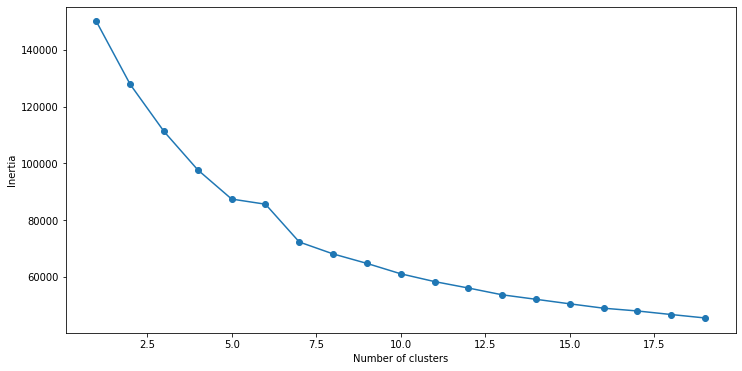

In [97]:
# Fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(data_scaled)
    SSE.append(kmeans.inertia_)

# Converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

Looking at the above elbow curve, we can choose any number of clusters between 5 to 9. Consider the number of clusters as 5 and fit the model:

In [98]:
# K Means using 5 clusters and k-means++ initialization
kmeans = KMeans(n_clusters = 5, init='k-means++')
kmeans.fit(data_scaled)
pred = kmeans.predict(data_scaled)

Value count of points in each of the above-formed clusters

In [99]:
frame = pd.DataFrame(data_scaled)
frame['cluster'] = pred
frame['cluster'].value_counts()

1    9406
4    3459
3    1363
0     736
2      36
Name: cluster, dtype: int64

So, there are 9406 data points belonging to cluster 1, then 36 points as least in cluster 2.

In [100]:
frame

,Year,Month,usg_apt_id,usg_wac,fg_apt_id,fg_wac,airlineid,carriergroup,Scheduled,Charter,Total,cluster
0,3.105373,-0.305506,0.327895,-0.236544,-1.286491,-0.920251,-1.880212,-1.437657,0.0,-0.352702,-0.352702,1
1,0.612833,-0.020022,0.042628,-0.357487,1.290262,1.759100,0.206107,-1.437657,0.0,-0.168997,-0.168997,4
2,-0.099322,1.692884,-0.349615,0.045658,-1.603167,-0.489820,0.155834,0.695576,0.0,-0.005760,-0.005760,1
3,-0.811476,-0.590990,0.105307,0.851947,1.401940,-0.920251,-0.196075,0.695576,0.0,-0.256357,-0.256357,1
4,-0.099322,1.692884,-0.220491,-1.486293,-1.232437,1.141814,0.075398,0.695576,0.0,-0.472010,-0.472010,1
...,...,...,...,...,...,...,...,...,...,...,...,...
14995,-0.099322,1.121915,0.064554,-0.357487,1.045998,0.194199,-0.356948,-1.437657,0.0,-0.381655,-0.381655,4
14996,-0.455399,-0.020022,-0.124147,-0.357487,-1.286491,-0.920251,0.294085,0.695576,0.0,-0.347710,-0.347710,1
14997,0.612833,1.407399,0.477394,-0.841261,-1.429276,-0.049379,2.272317,-1.437657,0.0,-0.508451,-0.508451,3
14998,-1.167553,1.121915,0.203423,-0.034971,-1.653652,-0.726724,0.354412,0.695576,0.0,-0.278821,-0.278821,1


In [101]:
# defining the kmeans function with initialization as k-means++
kmeans = KMeans(n_clusters=5, init='k-means++')

# fitting the k means algorithm on scaled data
kmeans.fit(data_scaled)

KMeans(n_clusters=5)

In [102]:
# inertia on the fitted data
kmeans.inertia_

87785.04383721764

In [103]:
df1 = frame[frame.cluster==0]
df2 = frame[frame.cluster==1]
df3 = frame[frame.cluster==2]
df4 = frame[frame.cluster==3]
df5 = frame[frame.cluster==4]

Scatter plot for number of clusters = 5

Text(0, 0.5, 'Total')

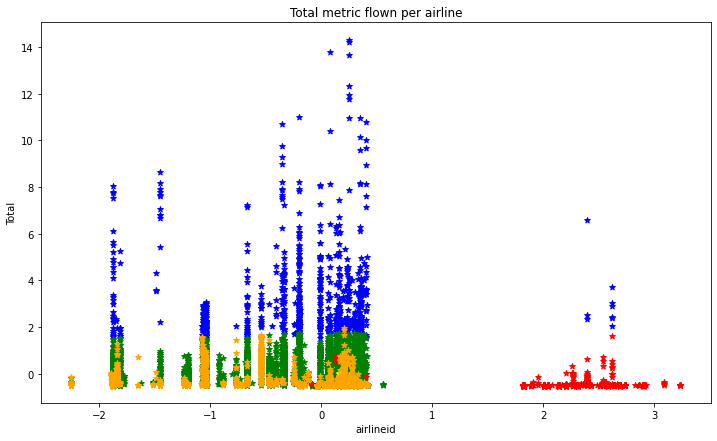

In [104]:
#Plot for cluster by kmeans
fig = plt.figure(figsize=(12,7))
plt.scatter(df1['airlineid'],df1['Total'],color='blue', marker='*')
plt.scatter(df2['airlineid'],df2['Total'],color='green', marker='*')
plt.scatter(df3['airlineid'],df3['Total'],color='yellow', marker='*')
plt.scatter(df4['airlineid'],df4['Total'],color='red', marker='*')
plt.scatter(df5['airlineid'],df5['Total'],color='orange',marker='*')
plt.title('Total metric flown per airline')
plt.xlabel('airlineid')
plt.ylabel('Total')

In [105]:
print(f'Silhouette Score(n=5): {silhouette_score(data_scaled,pred)}')

Silhouette Score(n=5): 0.3319439293681404


In [106]:
# k means using 6 clusters and k-means++ initialization
kmeans = KMeans(n_clusters = 6, init='k-means++')
kmeans.fit(data_scaled)
pred = kmeans.predict(data_scaled)

In [107]:
frame = pd.DataFrame(data_scaled)
frame['cluster'] = pred
frame['cluster'].value_counts()

0    7472
2    3459
1    1999
5    1363
3     671
4      36
Name: cluster, dtype: int64

In [108]:
frame

,Year,Month,usg_apt_id,usg_wac,fg_apt_id,fg_wac,airlineid,carriergroup,Scheduled,Charter,Total,cluster
0,3.105373,-0.305506,0.327895,-0.236544,-1.286491,-0.920251,-1.880212,-1.437657,0.0,-0.352702,-0.352702,1
1,0.612833,-0.020022,0.042628,-0.357487,1.290262,1.759100,0.206107,-1.437657,0.0,-0.168997,-0.168997,2
2,-0.099322,1.692884,-0.349615,0.045658,-1.603167,-0.489820,0.155834,0.695576,0.0,-0.005760,-0.005760,0
3,-0.811476,-0.590990,0.105307,0.851947,1.401940,-0.920251,-0.196075,0.695576,0.0,-0.256357,-0.256357,0
4,-0.099322,1.692884,-0.220491,-1.486293,-1.232437,1.141814,0.075398,0.695576,0.0,-0.472010,-0.472010,0
...,...,...,...,...,...,...,...,...,...,...,...,...
14995,-0.099322,1.121915,0.064554,-0.357487,1.045998,0.194199,-0.356948,-1.437657,0.0,-0.381655,-0.381655,2
14996,-0.455399,-0.020022,-0.124147,-0.357487,-1.286491,-0.920251,0.294085,0.695576,0.0,-0.347710,-0.347710,0
14997,0.612833,1.407399,0.477394,-0.841261,-1.429276,-0.049379,2.272317,-1.437657,0.0,-0.508451,-0.508451,5
14998,-1.167553,1.121915,0.203423,-0.034971,-1.653652,-0.726724,0.354412,0.695576,0.0,-0.278821,-0.278821,0


Scatter plot for number of clusters = 6

In [109]:
# Defining the kmeans function with initialization as k-means++
kmeans = KMeans(n_clusters=6, init='k-means++')

# Fitting the k means algorithm on scaled data
kmeans.fit(data_scaled)

# Prediction
pred = kmeans.predict(data_scaled)

In [110]:
# inertia on the fitted data
kmeans.inertia_

78549.18950404655

Text(0, 0.5, 'Total')

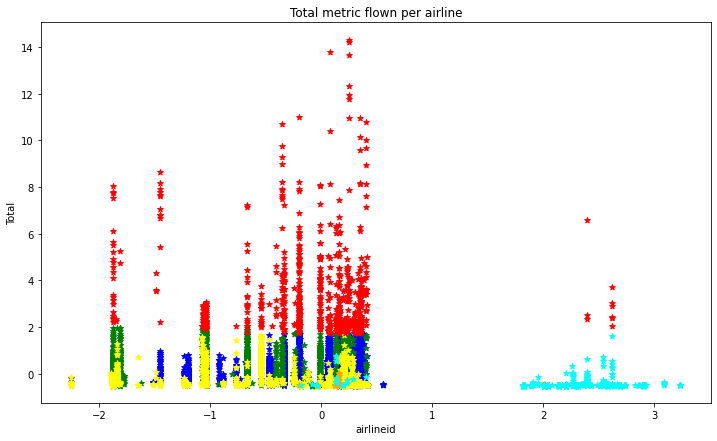

In [111]:
# Data Frames
df1 = frame[frame.cluster==0]
df2 = frame[frame.cluster==1]
df3 = frame[frame.cluster==2]
df4 = frame[frame.cluster==3]
df5 = frame[frame.cluster==4]
df6 = frame[frame.cluster==5]
#Plot for cluster by kmeans
fig = plt.figure(figsize=(12,7))
plt.scatter(df1['airlineid'],df1['Total'],color='blue', marker='*')
plt.scatter(df2['airlineid'],df2['Total'],color='green', marker='*')
plt.scatter(df3['airlineid'],df3['Total'],color='yellow', marker='*')
plt.scatter(df4['airlineid'],df4['Total'],color='red', marker='*')
plt.scatter(df5['airlineid'],df5['Total'],color='orange',marker='*')
plt.scatter(df6['airlineid'],df6['Total'],color='aqua',marker='*')
plt.title('Total metric flown per airline')
plt.xlabel('airlineid')
plt.ylabel('Total')

In [112]:
print(f'Silhouette Score(n=6): {silhouette_score(data_scaled,pred)}')

Silhouette Score(n=6): 0.2888648098698622


Scatter plot for number of clusters = 7

In [113]:
# defining the kmeans function with initialization as k-means++
kmeans = KMeans(n_clusters=7, init='k-means++')

# fitting the k means algorithm on scaled data
kmeans.fit(data_scaled)

pred = kmeans.predict(data_scaled)

In [114]:
frame = pd.DataFrame(data_scaled)
frame['cluster'] = pred
frame['cluster'].value_counts()

5    4505
0    3047
1    2970
6    2408
2    1363
3     671
4      36
Name: cluster, dtype: int64

K Means - Inertia

In [116]:
# inertia on the fitted data
kmeans.inertia_

73424.129743845

Text(0, 0.5, 'Total')

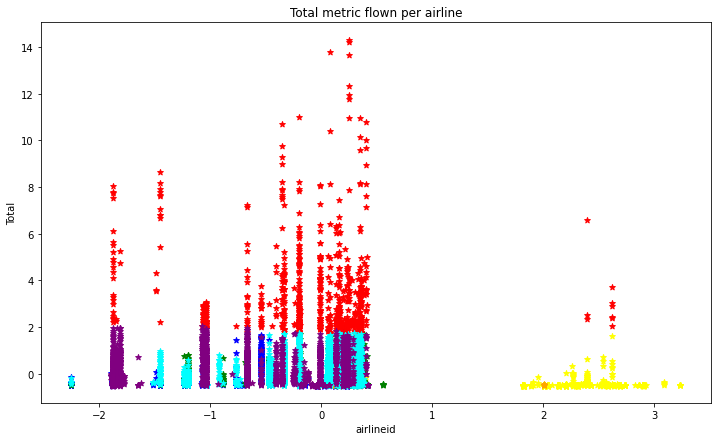

In [117]:
# Data Frames
df1 = frame[frame.cluster==0]
df2 = frame[frame.cluster==1]
df3 = frame[frame.cluster==2]
df4 = frame[frame.cluster==3]
df5 = frame[frame.cluster==4]
df6 = frame[frame.cluster==5]
df7 = frame[frame.cluster==6]
#Plot for cluster by kmeans
fig = plt.figure(figsize=(12,7))
plt.scatter(df1['airlineid'],df1['Total'],color='blue', marker='*')
plt.scatter(df2['airlineid'],df2['Total'],color='green', marker='*')
plt.scatter(df3['airlineid'],df3['Total'],color='yellow', marker='*')
plt.scatter(df4['airlineid'],df4['Total'],color='red', marker='*')
plt.scatter(df5['airlineid'],df5['Total'],color='orange',marker='*')
plt.scatter(df6['airlineid'],df6['Total'],color='aqua',marker='*')
plt.scatter(df7['airlineid'],df7['Total'],color='purple',marker='*')
plt.title('Total metric flown per airline')
plt.xlabel('airlineid')
plt.ylabel('Total')

In [118]:
print(f'Silhouette Score(n=7): {silhouette_score(data_scaled,pred)}')

Silhouette Score(n=7): 0.2937904247427518


Scatter plot for number of clusters = 8

In [119]:
# k means using 8 clusters and k-means++ initialization
kmeans = KMeans(n_clusters = 8, init='k-means++')
kmeans.fit(data_scaled)
pred = kmeans.predict(data_scaled)

In [120]:
frame = pd.DataFrame(data_scaled)
frame['cluster'] = pred
frame['cluster'].value_counts()

1    4505
0    3039
4    2408
5    1740
7    1338
2    1263
3     671
6      36
Name: cluster, dtype: int64

In [121]:
# inertia on the fitted data
kmeans.inertia_

69638.48450412774

Text(0, 0.5, 'Total')

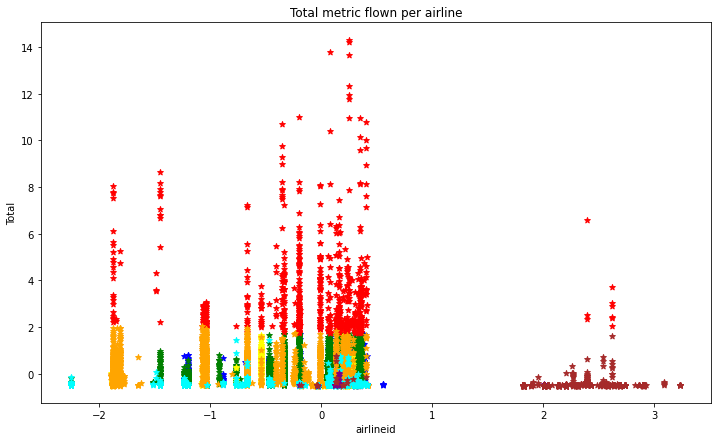

In [122]:
# Data Frames
df1 = frame[frame.cluster==0]
df2 = frame[frame.cluster==1]
df3 = frame[frame.cluster==2]
df4 = frame[frame.cluster==3]
df5 = frame[frame.cluster==4]
df6 = frame[frame.cluster==5]
df7 = frame[frame.cluster==6]
df8 = frame[frame.cluster==7]
#Plot for cluster by kmeans
fig = plt.figure(figsize=(12,7))
plt.scatter(df1['airlineid'],df1['Total'],color='blue', marker='*')
plt.scatter(df2['airlineid'],df2['Total'],color='green', marker='*')
plt.scatter(df3['airlineid'],df3['Total'],color='yellow', marker='*')
plt.scatter(df4['airlineid'],df4['Total'],color='red', marker='*')
plt.scatter(df5['airlineid'],df5['Total'],color='orange',marker='*')
plt.scatter(df6['airlineid'],df6['Total'],color='aqua',marker='*')
plt.scatter(df7['airlineid'],df7['Total'],color='purple',marker='*')
plt.scatter(df8['airlineid'],df8['Total'],color='brown',marker='*')
plt.title('Total metric flown per airline')
plt.xlabel('airlineid')
plt.ylabel('Total')

In [123]:
print(f'Silhouette Score(n=8): {silhouette_score(data_scaled,pred)}')

Silhouette Score(n=8): 0.26471056162303686


Scatter plot for number of clusters = 9

In [124]:
# k means using 9 clusters and k-means++ initialization
kmeans = KMeans(n_clusters = 9, init='k-means++')
kmeans.fit(data_scaled)
pred = kmeans.predict(data_scaled)

In [125]:
frame = pd.DataFrame(data_scaled)
frame['cluster'] = pred
frame['cluster'].value_counts()

7    2853
1    2687
0    2409
4    2004
6    1740
3    1338
2    1266
5     667
8      36
Name: cluster, dtype: int64

In [126]:
# defining the kmeans function with initialization as k-means++
kmeans = KMeans(n_clusters=9, init='k-means++')
# fitting the k means algorithm on scaled data
kmeans.fit(data_scaled)

KMeans(n_clusters=9)

In [127]:
# inertia on the fitted data
kmeans.inertia_

65593.6137821934

Text(0, 0.5, 'Total')

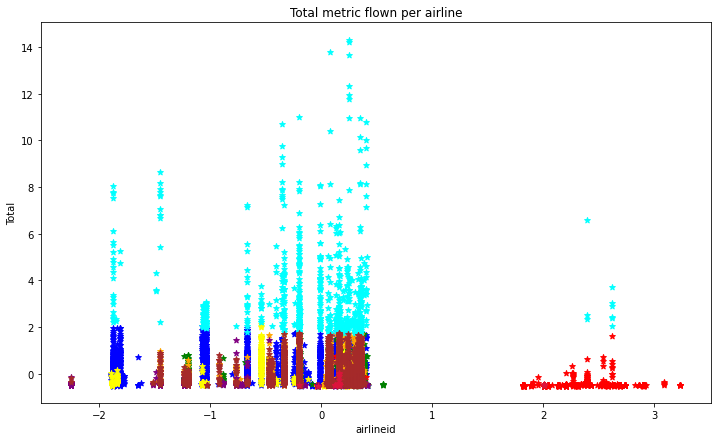

In [128]:
# Data Frames
df1 = frame[frame.cluster==0]
df2 = frame[frame.cluster==1]
df3 = frame[frame.cluster==2]
df4 = frame[frame.cluster==3]
df5 = frame[frame.cluster==4]
df6 = frame[frame.cluster==5]
df7 = frame[frame.cluster==6]
df8 = frame[frame.cluster==7]
df9 = frame[frame.cluster==8]
#Plot for cluster by kmeans
fig = plt.figure(figsize=(12,7))
plt.scatter(df1['airlineid'],df1['Total'],color='blue', marker='*')
plt.scatter(df2['airlineid'],df2['Total'],color='green', marker='*')
plt.scatter(df3['airlineid'],df3['Total'],color='yellow', marker='*')
plt.scatter(df4['airlineid'],df4['Total'],color='red', marker='*')
plt.scatter(df5['airlineid'],df5['Total'],color='orange',marker='*')
plt.scatter(df6['airlineid'],df6['Total'],color='aqua',marker='*')
plt.scatter(df7['airlineid'],df7['Total'],color='purple',marker='*')
plt.scatter(df8['airlineid'],df8['Total'],color='brown',marker='*')
plt.scatter(df9['airlineid'],df9['Total'],color='crimson',marker='*')
plt.title('Total metric flown per airline')
plt.xlabel('airlineid')
plt.ylabel('Total')

In [129]:
print(f'Silhouette Score(n=9): {silhouette_score(data_scaled,pred)}')

Silhouette Score(n=9): 0.34781151976014224
